In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.io as io
import matplotlib.pyplot as plt
from keras import utils as np_utils
import matplotlib.pyplot as plt
import sklearn.linear_model
import scipy.stats
import sklearn.metrics
import h5py
from keras.callbacks import EarlyStopping
from keras import models, layers, optimizers, backend, constraints, activations, losses
import complexnn
import TIMBRE.helpers as helpers

In [2]:
def csp(X1, y, ridge=0):
    #Trains a CSP filter bank without taking the conjugate in the function to compare accuracy to taking the conjugate inside the function

    unique_classes = np.unique(y)
    S = np.zeros((X1.shape[1], X1.shape[1], len(unique_classes)), dtype='complex')

    for i, u in enumerate(unique_classes):
        class_data = X1[y == u, :]
        S[:, :, i] = np.cov(class_data, rowvar=False) / np.sum(y == u)
        
    Ss = np.sum(S, axis=2)
    Ss += np.diag(np.diag(Ss)) * ridge

    W = np.zeros(S.shape, dtype='complex')
    lambda_vals = np.zeros((S.shape[0], S.shape[2]),dtype='complex')

    for i in range(S.shape[2]):
        eigvals, eigvecs = np.linalg.eig(np.linalg.inv(Ss).dot(S[:, :, i]))
        sorted_indices = np.argsort(eigvals)[::-1]
        lambda_vals[:, i] = eigvals[sorted_indices]
        W[:, :, i] = eigvecs[:, sorted_indices]

    return W, lambda_vals

In [3]:
def csp_conj(X1, y, ridge=0):
    #Trains a CSP filter bank taking the conjugate in the function to compare accuracy to without conjugate

    unique_classes = np.unique(y)
    S = np.zeros((X1.shape[1], X1.shape[1], len(unique_classes)), dtype='complex')

    for i, u in enumerate(unique_classes):
        class_data = X1[y == u, :]
        S[:, :, i] = np.cov(class_data, rowvar=False) / np.sum(y == u)
        
    Ss = np.sum(S, axis=2)
    Ss += np.diag(np.diag(Ss)) * ridge

    W = np.zeros(S.shape, dtype='complex')
    lambda_vals = np.zeros((S.shape[0], S.shape[2]),dtype='complex')

    for i in range(S.shape[2]):
        eigvals, eigvecs = np.linalg.eig(np.linalg.inv(Ss).dot(np.conj(S[:, :, i])))
        sorted_indices = np.argsort(eigvals)[::-1]
        lambda_vals[:, i] = eigvals[sorted_indices]
        W[:, :, i] = eigvecs[:, sorted_indices]

    return W, lambda_vals

In [4]:
#redefine TIMBRE function with legacy Adam optimizer so it will run on Mac

def TIMBRE(X, Y, inds_test, inds_train, hidden_nodes=0, learn_rate=.001, is_categorical=True, verbosity=0, save_path=None, filename=None):
    """
    Learns oscillatory patterns that are predictive of class labels

    Parameters:
    - X = Multi-channel data (T samples x N channels, complex-valued)
    - Y = Category labels (T samples, integer-valued)
    - inds_test = test indices (Either T x 1 boolean, or U x 1 integers)
    - inds_train = train indices (Either T x 1 boolean, or U x 1 integers)
    - hidden_nodes = how many nodes to use (no hidden layer if set to 0)
    - learn_rate = how quickly the network learns
    - is_categorical = whether the output consists of discrete classes
    - verbosity = amount of model training info to output (default = 0)

    Returns:
    - model: trained network
    - fittedModel: history of loss and accuracy for test and train data
    - test_acc: accuracy on test data after training
    """

    # stack the real and imaginary components of the data
    X = np.concatenate((np.real(X), np.imag(X)), axis=1)
    # use one-hot encoding for the class labels
    if is_categorical:
        Y = np_utils.to_categorical(Y)
        my_loss = 'categorical_crossentropy'
    else:
        my_loss = 'kde'
    backend.clear_session()
    # Early Stopping: stop training model when test loss stops decreasing
    es = EarlyStopping(monitor='val_loss', patience=1)
    # Specify the algorithm and step size used by gradient descent
    adam = optimizers.legacy.Adam(learning_rate=learn_rate)
    if hidden_nodes > 0:
        num_chans = hidden_nodes
    else:
        num_chans = Y.shape[1]
    model = models.Sequential()
    # Layer 1: Takes a complex-valued projection of the input
    model.add(complexnn.dense.ComplexDense(num_chans, input_shape=(X.shape[1],), use_bias=False,
                                           kernel_constraint=constraints.unit_norm()))
    # Layer 2: Converts complex-valued output of layer 0 to a real-valued magnitude
    model.add(layers.Lambda(lambda x: (x[:, :x.shape[1] // 2] ** 2 + x[:, x.shape[1] // 2:] ** 2) ** .5))
    # Layer 3: Softmax of layer 2
    model.add(layers.Activation(activations.softmax))
    if hidden_nodes > 0:  # Need another layer for output
        model.add(layers.Dense(Y.shape[1], activation='softmax'))
    model.compile(loss=my_loss, optimizer=adam, metrics=['accuracy'])
    # Train the model
    fittedModel = model.fit(X[inds_train, :], Y[inds_train, :], epochs=100,
                            verbose=0, validation_data=(X[inds_test, :], Y[inds_test, :]),
                            shuffle=True, callbacks=[es])
    test_acc = fittedModel.history['val_accuracy'][-1]
    
        #Save trained model (addition from original TIMBRE function)
    if filename:
        from keras.models import save_model
        save_model(model, filename + ".h5")
        
    return model, fittedModel, test_acc

In [5]:
def filter(matrix, range_low, range_high, btype='bp', fs = 1250/25, order = 3, use_hilbert = True):
    #Bandpass filter for specific broadbands 
    #TIMBRE filter function will not work for bandpass filters!
    nyq = 0.5*fs
    normal_range_low = range_low / nyq
    normal_range_high = range_high / nyq
    b, a = signal.butter(order, [normal_range_low, normal_range_high], btype=btype, analog=False)
    filt_X = signal.filtfilt(b, a, matrix, axis=0)
    return filt_X 

In [6]:
def band_whiten(X, inds_train, u, Xv):
    X = X @ np.conj(u.T)
    X = X / Xv
    return X

In [7]:
ffs_costs = [0, -1, -2, -3, -4, -5, -6] #different fudge factors/levels of regularization 

accs = np.zeros((3*len(ffs_costs)+2,3,5))
cross_entropy = np.zeros((4*len(ffs_costs)+2,3,5))

In [8]:
for i in range(1,5):
    data = io.loadmat(f'data0{i}.mat') #load drudged data to train models
    lapID = data['lapID']
    theta_preHilbert = filter(data['lfps'], range_low = 6, range_high = 12, btype= 'bp',order= 2) 
    harm_preHilbert = filter(data['lfps'], range_low = 14, range_high = 20, btype= 'bp',order= 2)

    theta_LFPs = signal.hilbert(theta_preHilbert, axis= 0)
    harm_LFPs = signal.hilbert(harm_preHilbert, axis= 0)
    double_LFPs = np.abs(theta_LFPs)*np.exp(np.angle(theta_LFPs)*2*1j)
    
    inds_test, inds_train = helpers.test_train(lapID, 1, n_folds=5, which_fold=0)
    
    for j,c in enumerate(ffs_costs): #run csp withOUT conjugate in function
        theta_csp, theta_lambdas = csp(theta_LFPs[inds_train], lapID[:, 1][inds_train], ridge = 10**c)
        theta_data = np.abs(np.conj(theta_LFPs)@theta_csp[:,:1,:].reshape((theta_csp.shape[0], -1))) #take conjugate here
        CSP_model = sklearn.linear_model.LogisticRegression(penalty=None).fit(theta_data[inds_train],lapID[inds_train,1])
    
        theta_predictions = CSP_model.predict(theta_data[inds_test])
        theta_acc = np.mean(theta_predictions == lapID[inds_test, 1])
        theta_probs = CSP_model.predict_proba(theta_data[inds_test])
        true_labels = lapID[inds_test, 1]
        theta_cross_entropy = sklearn.metrics.log_loss(true_labels, theta_probs)

        harm_data = np.abs(np.conj(harm_LFPs)@theta_csp[:,:1,:].reshape((theta_csp.shape[0], -1)))
        harm_predictions = CSP_model.predict(harm_data[inds_test])
        harm_acc = np.mean(harm_predictions == lapID[inds_test, 1])
        harm_probs = CSP_model.predict_proba(harm_data[inds_test])
        harm_cross_entropy = sklearn.metrics.log_loss(true_labels, harm_probs)
    
        double_data = np.abs(np.conj(double_LFPs)@theta_csp[:,:1,:].reshape((theta_csp.shape[0], -1)))
        double_predictions = CSP_model.predict(double_data[inds_test])
        double_acc = np.mean(double_predictions == lapID[inds_test, 1])
        double_probs = CSP_model.predict_proba(double_data[inds_test])
        double_cross_entropy = sklearn.metrics.log_loss(true_labels, double_probs)
    
        accs[j+2,:,i] = [theta_acc, harm_acc, double_acc]
        cross_entropy[j+2,:,i] = [theta_cross_entropy, harm_cross_entropy, double_cross_entropy]
    
    for j,c in enumerate(ffs_costs): #run csp with conjugate in function
        theta_csp, theta_lambdas = csp_conj(theta_LFPs[inds_train], lapID[:, 1][inds_train], ridge = 10**c)
        theta_data = np.abs(theta_LFPs@theta_csp[:,:1,:].reshape((theta_csp.shape[0], -1))) 
        CSP_model = sklearn.linear_model.LogisticRegression(penalty=None).fit(theta_data[inds_train],lapID[inds_train,1])
    
        theta_predictions = CSP_model.predict(theta_data[inds_test])
        theta_acc = np.mean(theta_predictions == lapID[inds_test, 1])
        theta_probs = CSP_model.predict_proba(theta_data[inds_test])
        true_labels = lapID[inds_test, 1]
        theta_cross_entropy = sklearn.metrics.log_loss(true_labels, theta_probs)

        harm_data = np.abs(harm_LFPs@theta_csp[:,:1,:].reshape((theta_csp.shape[0], -1)))
        harm_predictions = CSP_model.predict(harm_data[inds_test])
        harm_acc = np.mean(harm_predictions == lapID[inds_test, 1])
        harm_probs = CSP_model.predict_proba(harm_data[inds_test])
        harm_cross_entropy = sklearn.metrics.log_loss(true_labels, harm_probs)
    
        double_data = np.abs(double_LFPs@theta_csp[:,:1,:].reshape((theta_csp.shape[0], -1)))
        double_predictions = CSP_model.predict(double_data[inds_test])
        double_acc = np.mean(double_predictions == lapID[inds_test, 1])
        double_probs = CSP_model.predict_proba(double_data[inds_test])
        double_cross_entropy = sklearn.metrics.log_loss(true_labels, double_probs)
    
        accs[j+len(ffs_costs)+2,:,i] = [theta_acc, harm_acc, double_acc]
        cross_entropy[j+len(ffs_costs)+2,:,i] = [theta_acc, harm_acc, double_acc]
     
     #TIMBRE MODELS   
    full_LFPs = helpers.filter_data(data['lfps'], 2, fs=1250/25, use_hilbert=True)

    w_full, u, Xv = helpers.whiten(full_LFPs, inds_train)
    w_theta = band_whiten(theta_LFPs, inds_train, u, Xv)
    w_harm = band_whiten(harm_LFPs, inds_train, u, Xv)
    w_double = band_whiten(double_LFPs, inds_train, u, Xv)
    
    test_theta = np.concatenate((np.real(w_theta), np.imag(w_theta)), axis=1)
    test_harm = np.concatenate((np.real(w_harm), np.imag(w_harm)), axis=1)
    test_double = np.concatenate((np.real(w_double), np.imag(w_double)), axis=1)

    test_Y = np_utils.to_categorical(lapID[:, 1]) #one-hot encode LapID for testing
    
    n3_model, n3_fittedModel, n3_test_acc = TIMBRE(w_theta, lapID[:, 1], inds_test, inds_train, hidden_nodes=3, save_path="", filename=f"3n_theta_model{i}")
    n0_model, n0_fittedModel, n0_test_acc = TIMBRE(w_theta, lapID[:, 1], inds_test, inds_train, hidden_nodes=0, save_path="", filename=f"0n_theta_model{i}")
    
    TIMBRE_models = [n3_model, n0_model]
    test_data = [test_theta, test_harm, test_double]

    for k in range(len(TIMBRE_models)):
        for j in range(len(test_data)):
            cross_entropy[k,j,i], accs[k,j,i] = TIMBRE_models[k].evaluate(test_data[j][inds_test, :], test_Y[inds_test, :])
    
    
    #Logistic regression of amplitudes
    theta_amps = np.abs(theta_LFPs)
    harm_amps = np.abs(harm_LFPs)
    double_amps = np.abs(double_LFPs) #should be the same as theta
    
    for j,c in enumerate(ffs_costs):
        log_model = sklearn.linear_model.LogisticRegression(penalty='l2', C = 10**c).fit(theta_amps[inds_train],lapID[inds_train,1])

        theta_predictions = log_model.predict(theta_amps[inds_test])
        theta_acc = np.mean(theta_predictions == lapID[inds_test, 1])
        theta_probs = log_model.predict_proba(theta_amps[inds_test])
        true_labels = lapID[inds_test, 1]
        theta_cross_entropy = sklearn.metrics.log_loss(true_labels, theta_probs)

        harm_predictions = log_model.predict(harm_amps[inds_test])
        harm_acc = np.mean(harm_predictions == lapID[inds_test, 1])
        harm_probs = log_model.predict_proba(harm_amps[inds_test])
        harm_cross_entropy = sklearn.metrics.log_loss(true_labels, harm_probs)
    
        double_predictions = log_model.predict(double_amps[inds_test])
        double_acc = np.mean(double_predictions == lapID[inds_test, 1])
        double_probs = log_model.predict_proba(double_amps[inds_test])
        double_cross_entropy = sklearn.metrics.log_loss(true_labels, double_probs)
    
        accs[j+2*len(ffs_costs)+2,:,i] = [theta_acc, harm_acc, double_acc]
        cross_entropy[j+2*len(ffs_costs)+2,:,i] = [theta_acc, harm_acc, double_acc]
        
    print(i)
    print(accs[:,:,i])
    print(cross_entropy[:,:,i])

/Users/aimeejohnston/Desktop/beatLab/fnproject/fnve/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aimeejohnston/Desktop/beatLab/fnproject/fnve/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

101/101 [==============================] - 0s 293us/step - loss: 0.6479 - accuracy: 0.7728


/Users/aimeejohnston/Desktop/beatLab/fnproject/fnve/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aimeejohnston/Desktop/beatLab/fnproject/fnve/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

ValueError: Complex data not supported
[[-0.10709171-9.94249146e-01j -0.03469003-9.99398120e-01j
   0.66515586-7.46704551e-01j ... -0.03312588-9.99451187e-01j
   0.00628418-9.99980254e-01j  0.10560303-9.94408367e-01j]
 [ 0.59203481+8.05912391e-01j  0.51399215+8.57794885e-01j
  -0.10088136+9.94898463e-01j ...  0.55243836+8.33553754e-01j
   0.52162655+8.53173924e-01j  0.4281124 +9.03725496e-01j]
 [ 0.86399987-5.03492037e-01j  0.89569467-4.44669597e-01j
   0.80152051+5.97967277e-01j ...  0.99325251+1.15971776e-01j
   0.98447057+1.75549693e-01j  0.96380517+2.66607557e-01j]
 ...
 [ 0.96126299-2.75632849e-01j  0.9994165 +3.41563632e-02j
   0.41006849+9.12054733e-01j ...  0.99515629+9.83054591e-02j
   0.98743483+1.58026778e-01j  0.9477816 +3.18920106e-01j]
 [ 0.39960862+9.16685852e-01j  0.22539945+9.74266435e-01j
  -0.99999959-9.09227674e-04j ... -0.2012774 +9.79534282e-01j
  -0.27611696+9.61124042e-01j -0.41766683+9.08600253e-01j]
 [-0.46933573+8.83019804e-01j -0.75853606+6.51631065e-01j
  -0.80230467-5.96914742e-01j ... -0.98670181+1.62540882e-01j
  -0.9953772 +9.60428480e-02j -0.99897703-4.52204981e-02j]]


In [ ]:
#Average across sessions
avg_accs = np.mean(accs[:,:,1:], axis = 2)
avg_cross = np.mean(accs[:,:,1:], axis = 2)

print(avg_accs)
print(avg_cross)

[[0.95922603 0.64912374 0.76105833]
 [0.96517305 0.63208063 0.75136274]
 [0.57731832 0.27548311 0.51519266]
 [0.69581461 0.42294491 0.48576188]
 [0.82174317 0.46852759 0.52518959]
 [0.88299605 0.5555791  0.52101884]
 [0.90103805 0.60362867 0.6028221 ]
 [0.88646648 0.60238648 0.56762992]
 [0.87778006 0.58599775 0.54937186]
 [0.61024803 0.35391316 0.52122044]
 [0.70279745 0.42125588 0.566838  ]
 [0.81607802 0.48084447 0.52637549]
 [0.85590024 0.49271259 0.52574369]
 [0.86121074 0.49428304 0.5721104 ]
 [0.85762086 0.50670577 0.57327986]
 [0.85352155 0.51141303 0.54644118]
 [0.77026738 0.45331968 0.77026738]
 [0.77297303 0.45619512 0.77297303]
 [0.76087668 0.45121135 0.76087668]
 [0.75713571 0.45014745 0.75713571]
 [0.77288557 0.45273973 0.77288557]
 [0.76821906 0.45099662 0.76821906]
 [0.76492218 0.44321835 0.76492218]]
[[0.95922603 0.64912374 0.76105833]
 [0.96517305 0.63208063 0.75136274]
 [0.57731832 0.27548311 0.51519266]
 [0.69581461 0.42294491 0.48576188]
 [0.82174317 0.46852759 0.5

In [ ]:
theta_accs = avg_accs[:,0]
harm_accs = avg_accs[:,1]
double_accs = avg_accs[:,2]

print(len(theta_accs))


23


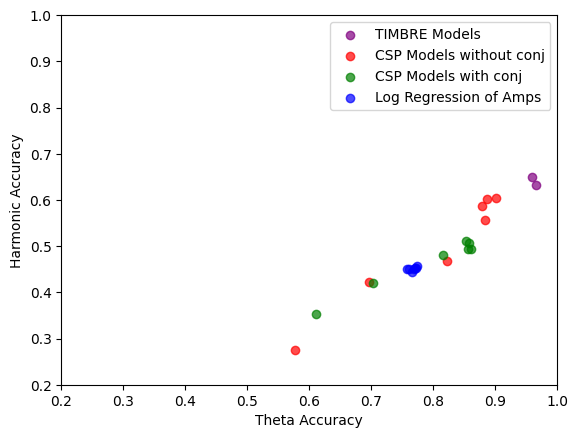

In [ ]:
plt.scatter(theta_accs[:2], harm_accs[:2], c='Purple', label='TIMBRE Models', alpha = 0.7)
plt.scatter(theta_accs[2:9], harm_accs[2:9], c='Red', label='CSP Models without conj', alpha = 0.7)
plt.scatter(theta_accs[9:16], harm_accs[9:16], c='Green', label='CSP Models with conj', alpha = 0.7)
plt.scatter(theta_accs[16:23], harm_accs[16:23], c='Blue', label='Log Regression of Amps', alpha = 0.7)
plt.scatter(theta_accs[23:], harm_accs[23:], c='Orange', label='Log Regression of Phase', alpha = 0.7)


plt.xlabel('Theta Accuracy')
plt.ylabel('Harmonic Accuracy')

plt.xlim(0.2, 1)
plt.ylim(0.2, 1)

plt.legend()
plt.show()

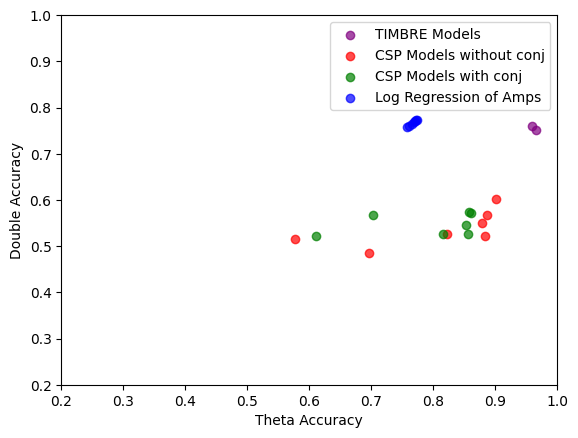

In [ ]:
plt.scatter(theta_accs[:2], double_accs[:2], c='Purple', label='TIMBRE Models', alpha = 0.7)
plt.scatter(theta_accs[2:9], double_accs[2:9], c='Red', label='CSP Models without conj', alpha = 0.7)
plt.scatter(theta_accs[9:16], double_accs[9:16], c='Green', label='CSP Models with conj', alpha = 0.7)
plt.scatter(theta_accs[16:23], double_accs[16:23], c='Blue', label='Log Regression of Amps', alpha = 0.7)
plt.scatter(theta_accs[23:], double_accs[23:], c='Orange', label='Log Regression of Phase', alpha = 0.7)


plt.xlabel('Theta Accuracy')
plt.ylabel('Double Accuracy')

plt.xlim(0.2, 1)
plt.ylim(0.2, 1)

plt.legend()
plt.show()

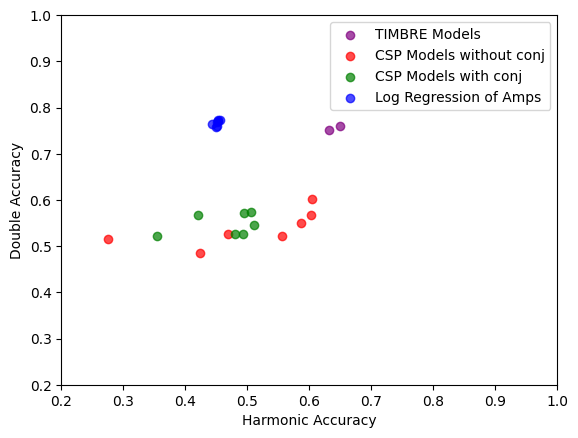

In [ ]:
plt.scatter(harm_accs[:2], double_accs[:2], c='Purple', label='TIMBRE Models', alpha = 0.7)
plt.scatter(harm_accs[2:9], double_accs[2:9], c='Red', label='CSP Models without conj', alpha = 0.7)
plt.scatter(harm_accs[9:16], double_accs[9:16], c='Green', label='CSP Models with conj', alpha = 0.7)
plt.scatter(harm_accs[16:24], double_accs[16:24], c='Blue', label='Log Regression of Amps', alpha = 0.7)
plt.scatter(harm_accs[24:], double_accs[24:], c='Orange', label='Log Regression of Phase', alpha = 0.7)


plt.xlabel('Harmonic Accuracy')
plt.ylabel('Double Accuracy')

plt.xlim(0.2, 1)
plt.ylim(0.2, 1)

plt.legend()
plt.show()